In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import tomli
from scipy.optimize import curve_fit

In [125]:
def read_experiment_file(filename):
    metadata = {}
    data = []
    
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Parse metadata
    data_start = None
    for i, line in enumerate(lines):
        if line.strip() == "":
            continue
        
        parts = line.split('\t')
        if len(parts) == 2 and not parts[0].replace('.', '', 1).isdigit():
            key, value = parts
            metadata[key.strip()] = value.strip()
        elif "Current / A" in parts[0]:
            data_start = i + 1
            break
    
    # Read numerical data
    if data_start is not None:
        for line in lines[data_start:]:
            values = line.split('\t')
            if len(values) == 3:
                try:
                    data.append([float(v) for v in values])
                except ValueError:
                    continue  # Skip malformed lines
    
    df = pd.DataFrame(data, columns=["Current (A)", "Voltage (uV)", "Time (s)"])
    
    return metadata, df

In [126]:
filename = "data/Ic_Data.txt"  # Change this to your actual file path
metadata, df = read_experiment_file(filename)

print("Metadata:", metadata)
print("Data:")
print(df.head())

Metadata: {'Sample': '2mm tape', 'date': '07/01/2025', 'Temperature (K)': '77.00', 'Angle (deg.)': '0.000000', 'field / T': '0.000000'}
Data:
   Current (A)  Voltage (uV)  Time (s)
0    -0.022416     -1.681175     0.000
1    -0.022637     -1.692240     0.283
2    -0.023539     -1.706892     0.328
3     0.080704     -1.971687     0.415
4     0.100873     -1.813486     1.006


In [127]:
# Convert dataframe columns to NumPy arrays
current = df["Current (A)"].to_numpy()
voltage = df["Voltage (uV)"].to_numpy()
time = df["Time (s)"].to_numpy()

print(current[:5])  # Print first 5 values as a check
print(voltage[:5])
print(time[:5])

[-0.022416 -0.022637 -0.023539  0.080704  0.100873]
[-1.681175 -1.69224  -1.706892 -1.971687 -1.813486]
[0.    0.283 0.328 0.415 1.006]


In [128]:
def sigmoid(x):
     return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x))) 

In [129]:
def discontinous(time,a,b,c,d,n):
    y = time-b
    return a*time+c + d*sigmoid(y/10)*np.abs(y)**np.clip(n, -10, 10)

In [130]:
def piecewise_function(x, a, b, c, n, x_transition):
    """Piecewise function: linear for x < x_transition, power-law for x >= x_transition."""
    y = np.piecewise(x, 
                      [x < x_transition, x >= x_transition], 
                      [lambda x: a * x + b, 
                       lambda x: c * (x ** n)])
    return y

In [143]:
def straight_line(time,a,b):
    return a*time+b

In [131]:
def shouldnt(time,a,b,c,d,n):
    return a*time +b + c(time+d)**n

In [161]:
def plot_voltage(time, voltage, savefig,name,ax=None):
    p0 = [0.04, 158, -3, 0.01, 2.6] 
    if ax is not None:
       ax = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    popt, pcov = curve_fit(discontinous, time, voltage,p0=p0,bounds=([0, 0, -3, 0, 0],[1, 170, 3, 1, 10]))
    #popt, pcov = curve_fit(straight_line, time, voltage)
    plt.plot(time,voltage)
    plt.plot(time, discontinous(time,*popt), label="Fitted Curve", color="blue")
    plt.plot(time, discontinous(time,*p0), label="Fitted Curve", color="green")
    #plt.plot(time, straight_line(time,*popt), label="Fitted Curve", color="blue")
    plt.xlabel("Time")
    plt.ylabel("Voltage")
    if savefig:
        plt.savefig(os.getcwd() + "/" + name)
    return ax

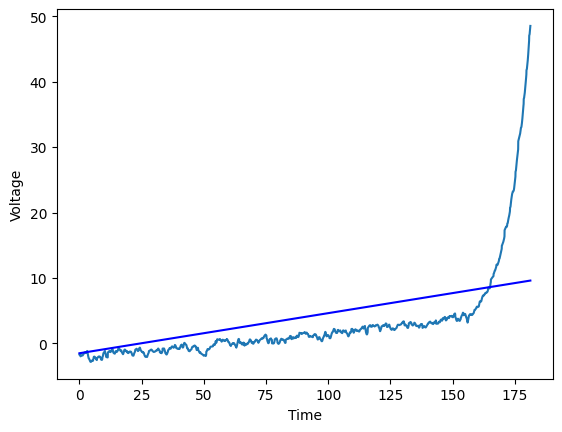

In [160]:
plot_voltage(time,voltage,0,"plot_1")